# Deep Factorization Machines

For real-world data where inherent feature crossing structures are usually very complex and nonlinear, second-order feature interactions  generally used in factorization machines in practice are often insufficient. Modeling higher degrees of feature combinations with factorization machines is possible theoretically but it is usually not adopted due to numerical instability and high computational complexity. One effective solution is using deep neural networks. 

Deep neural networks are powerful in feature representation learning and have the potential to learn sophisticated feature interactions. As such, it is natural to integrate deep neural networks to factorization machines. Adding nonlinear transformation layers to factorization machines gives it the capability to model both low-order feature combinations and high-order feature combinations. Moreover, non-linear inherent structures from inputs can also be captured with deep neural networks. As such, we will train a representative model named deep factorization machines (DeepFM) [Guo et al., 2017] which combine FM and deep neural networks.

DeepFM consists of an FM component and a deep component which are integrated in a parallel structure. The FM component is the same as the 2-way factorization machines which is used to model the low-order feature interactions. The deep component is a multi-layered perceptron that is used to capture high-order feature interactions and nonlinearities. These two components share the same inputs/embeddings and their outputs are summed up as the final prediction. It is worth pointing out that the spirit of DeepFM resembles that of the Wide & Deep architecture which can capture both memorization and generalization. The advantages of DeepFM over the Wide & Deep model is that it reduces the effort of hand-crafted feature engineering by identifying feature combinations automatically.

![](https://drive.google.com/uc?id=1KXC_8TRNC5Dj1w_NyDfyagzxAnbQDABb)



* Integrating neural networks to FM enables it to model complex and high-order 
interactions.

* DeepFM outperforms the original FM on the advertising dataset.


# Model implementation in PyTorch

In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(2020)

import warnings
warnings.filterwarnings('ignore')

In [2]:
class MovieLensDataset(Dataset):
    """
        MovieLens 1M Dataset
        Data preparation: treat samples with a rating less than 3 as negative samples
        :param dataset_path: MovieLens dataset path
    """

    def __init__(self, dataset_path, sep='::', engine='python', header=None):
        # Read the data into a Pandas dataframe
        data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header).to_numpy()[:, :3]

        # Retrieve the items and ratings data
        self.items = data[:, :2].astype(np.int) - 1  # -1 because ID begins from 1
        self.targets = self.__preprocess_target(data[:, 2]).astype(np.float32)

        # Get the range of the items ([6040, 3952])
        self.field_dims = np.max(self.items, axis=0) + 1 

        # Initialize NumPy arrays to store user and item indices
        self.user_field_idx = np.array((0,), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        """
        :return: number of total ratings
        """
        return self.targets.shape[0]

    def __getitem__(self, index):
        """
        :param index: current index
        :return: the items and ratings at current index
        """
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        """
        Preprocess the ratings into negative and positive samples
        :param target: ratings
        :return: binary ratings (0 or 1)
        """
        target[target <= 3] = 0  # ratings less than or equal to 3 classified as 0
        target[target > 3] = 1  # ratings bigger than 3 classified as 1
        return target

In [3]:
class DeepFM(nn.Module):
  """
  A Pytorch implementation of Deep Factorization Model
  """

  def __init__(self, field_dims, embed_dim, mlp_dims, dropout):
    super(DeepFM, self).__init__()
    self.embedding = FeaturesEmbedding(field_dims, embed_dim)
    self.linear = FeaturesLinear(field_dims)
    self.fm = FactorizationMachine(reduce_sum=True)
    self.embed_output_dim = len(field_dims) * embed_dim
    self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout)

  def forward(self, x):
    """
    :param x: Long tensor of size (batch_size, num_fields)
    """
    embed_x = self.embedding(x)
    x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))
    return torch.sigmoid(x.squeeze(1))

In [4]:
class FeaturesEmbedding(torch.nn.Module):
    """
    Class to get feature embeddings
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)


class FeaturesLinear(torch.nn.Module):
    """
    Class to perform a linear transformation on the features
    """

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class MultiLayerPerceptron(torch.nn.Module):
    """
    Class to instantiate a Multilayer Perceptron model
    """

    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        return self.mlp(x)


class FactorizationMachine(torch.nn.Module):
    """
        Class to instantiate a Factorization Machine model
    """

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

In [5]:
def fit(model, optimizer, data_loader, criterion, device, log_interval=1000):
    """
    Train the model
    :param model: choice of model
    :param optimizer: choice of optimizer
    :param data_loader: data loader class
    :param criterion: choice of loss function
    :param device: choice of device
    :return: loss being logged
    """
    # Step into train mode
    model.train()
    total_loss = 0
    for i, (fields, target) in enumerate(data_loader):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Log the total loss for every 1000 runs
        #if (i + 1) % log_interval == 0:
        #    print('    - loss:', total_loss / log_interval)
        #    total_loss = 0

def test(model, data_loader, device):
    """
    Evaluate the model
    :param model: choice of model
    :param data_loader: data loader class
    :param device: choice of device
    :return: AUC score
    """
    # Step into evaluation mode
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in data_loader:
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())

    # Return AUC score between predicted ratings and actual ratings
    return roc_auc_score(targets, predicts)

In [6]:
# get the data
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-08-31 09:51:31--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  33.1MB/s    in 0.2s    

2021-08-31 09:51:31 (33.1 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [7]:
# Get the dataset
dataset = MovieLensDataset('./ml-1m/ratings.dat')

# Split the data into 80% train, 10% validation, and 10% test
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
test_length = len(dataset) - train_length - valid_length
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_length, valid_length, test_length))

# Instantiate data loader classes for train, validation, and test sets
train_data_loader = DataLoader(train_dataset, batch_size=1024, num_workers=8)
valid_data_loader = DataLoader(valid_dataset, batch_size=1024, num_workers=8)
test_data_loader = DataLoader(test_dataset, batch_size=1024, num_workers=8)

In [8]:
# Get the model
field_dims = dataset.field_dims
learning_rate=0.001
weight_decay=1e-6
epoch=50
device='cpu'

model = DeepFM(field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.5)
# Use binary cross entropy loss
criterion = torch.nn.BCELoss()
# Use Adam optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

valid_losses = []

# Loop through pre-defined number of epochs
for epoch_i in range(epoch):
    # Perform training on the train set
    train_auc = fit(model, optimizer, train_data_loader, criterion, device)
    # Perform evaluation on the validation set
    valid_auc = test(model, valid_data_loader, device)
    # Log the epochs and AUC on the validation set
    print('epoch:', epoch_i, 'validation: auc:', valid_auc)
    valid_losses.append(valid_auc)

# Perform evaluation on the test set
test_auc = test(model, test_data_loader, device)
# Log the final AUC on the test set
print('test auc:', test_auc)

# Save the model checkpoint
torch.save(model.state_dict(), 'deepfm.pt')

epoch: 0 validation: auc: 0.7748855875414413
epoch: 1 validation: auc: 0.7809107389282749
epoch: 2 validation: auc: 0.7825578235461339
epoch: 3 validation: auc: 0.784763771780618
epoch: 4 validation: auc: 0.7854905713543625
epoch: 5 validation: auc: 0.7859309643393357
epoch: 6 validation: auc: 0.7872158641677103
epoch: 7 validation: auc: 0.7883527151325715
epoch: 8 validation: auc: 0.7899074102445225
epoch: 9 validation: auc: 0.7905981871911703
epoch: 10 validation: auc: 0.7914434526920313
epoch: 11 validation: auc: 0.79235680468287
epoch: 12 validation: auc: 0.7929104501516231
epoch: 13 validation: auc: 0.794071345178426
epoch: 14 validation: auc: 0.7947003129170545
epoch: 15 validation: auc: 0.7956855767987371
epoch: 16 validation: auc: 0.7961771596281977
epoch: 17 validation: auc: 0.7972665811041233
epoch: 18 validation: auc: 0.7982736429389404
epoch: 19 validation: auc: 0.7986405588546166
epoch: 20 validation: auc: 0.7992968384663428
epoch: 21 validation: auc: 0.8000116600885672
ep

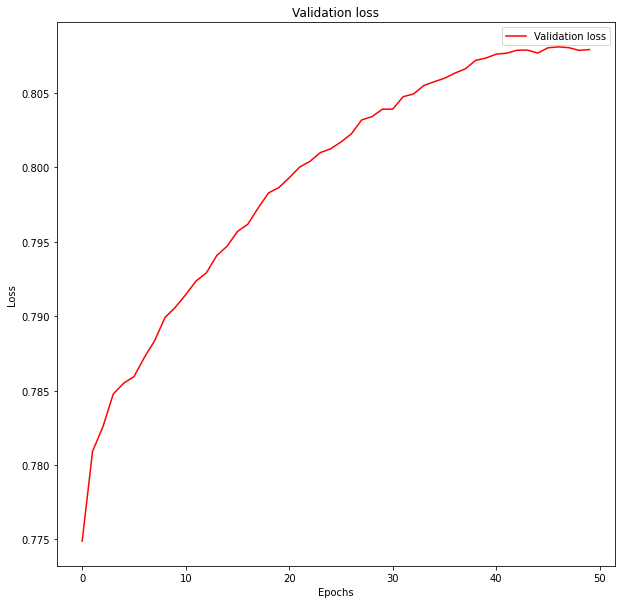

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot( valid_losses, 'r', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()